# Proyek Klasifikasi Gambar

## Import Semua Packages/Library yang Digunakan

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub
import shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import random
from collections import Counter
from PIL import Image
import imghdr
from pathlib import Path
import json
import glob
import re

In [4]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [5]:
print(f'\nTensorflow version = {tf.__version__}\n')
print(f'\n{tf.config.list_physical_devices("GPU")}\n')


Tensorflow version = 2.18.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



In [6]:
!nvidia-smi

Sun Jun  8 07:53:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training enabled")
except Exception as e:
    print(f"Could not enable mixed precision: {e}")

Mixed precision training enabled


## Data Preparation

In [8]:
import os
from google.colab import drive

# Pasang Google Drive (opsional jika ingin simpan hasil)
# drive.mount('/content/drive')

# Setup kaggle.json (tanpa input prompt)
os.environ['KAGGLE_USERNAME'] = 'kaggle_username'
os.environ['KAGGLE_KEY'] = 'kaggle_key'


In [9]:
import kaggle
import shutil

data_dir = "/content/data"
os.makedirs(data_dir, exist_ok=True)

# Download dan unzip dataset
!kaggle datasets download -d aayushpurswani/diamond-images-dataset -p "{data_dir}" --unzip

# Cek hasil unzip
print("File setelah diekstrak:")
print(os.listdir(data_dir))


Dataset URL: https://www.kaggle.com/datasets/aayushpurswani/diamond-images-dataset
License(s): MIT
100% 3.07G/3.08G [00:29<00:00, 51.9MB/s]
100% 3.08G/3.08G [00:29<00:00, 112MB/s] 
File setelah diekstrak:
['web_scraped']


### Data Loading

In [10]:
base_dir = os.path.join(data_dir, "web_scraped")  # sesuai struktur zip

# Validasi isi folder
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Folder {base_dir} tidak ditemukan. Cek isi data_dir: {os.listdir(data_dir)}")


In [11]:
def remove_non_image_files(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    removed_count = 0

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            _, ext = os.path.splitext(file_path.lower())

            if ext not in image_extensions:
                print(f"Menghapus file non-gambar: {file_path}")
                os.remove(file_path)
                removed_count += 1

    return removed_count

# Panggil fungsi setelah definisi
removed_files = remove_non_image_files(base_dir)
print(f"File non-gambar dihapus: {removed_files}")


Menghapus file non-gambar: /content/data/web_scraped/diamond_data.csv
File non-gambar dihapus: 1


In [12]:
def validate_images(data_dir):
    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    invalid_images = []

    for filepath in Path(data_dir).rglob("*"):
        if filepath.is_file() and filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} tidak valid")
                invalid_images.append(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} adalah {img_type}, tidak kompatibel dengan TensorFlow")
                invalid_images.append(filepath)

    for filepath in invalid_images:
        filepath.unlink()
    print(f"File invalid {len(invalid_images)} berhasil dihapus")


In [13]:
# Bersihkan file non-gambar
removed_files = remove_non_image_files(base_dir)
print(f"File non-gambar dihapus: {removed_files}")

# Validasi format dan hapus gambar corrupt
validate_images(base_dir)


File non-gambar dihapus: 0
/content/data/web_scraped/emerald/220188-630.jpg tidak valid
File invalid 1 berhasil dihapus


In [14]:
os.listdir(base_dir)

['marquise',
 'emerald',
 'round',
 'cushion',
 'oval',
 'princess',
 'heart',
 'pear']

In [15]:
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(f"Ditemukan {len(classes)} kelas: {classes}")

Ditemukan 8 kelas: ['marquise', 'emerald', 'round', 'cushion', 'oval', 'princess', 'heart', 'pear']


In [16]:
def check_image_resolutions(base_dir, sample_size=50):
    resolutions = []
    image_paths = []
    class_images = {}

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        sample_files = random.sample(image_files, min(sample_size, len(image_files)))

        for img_file in sample_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    resolutions.append((width, height))
                    image_paths.append(img_path)

                    if class_name not in class_images:
                        class_images[class_name] = []

                    if len(class_images[class_name]) < 3:
                        class_images[class_name].append(img_path)
            except Exception as e:
                print(f"Error dengan {img_path}: {e}")

    return resolutions, image_paths, class_images

In [17]:
resolutions, image_paths, class_images = check_image_resolutions(base_dir)

In [18]:
resolution_counts = Counter(resolutions)
most_common_resolutions = resolution_counts.most_common(10)

In [19]:
print(f"Ditemukan {len(set(resolutions))} dengan resolusi gambar berbeda di sampel data")
print("\nTop 10 resolusi:")
for res, count in most_common_resolutions:
    print(f"  {res[0]}×{res[1]} pixel: {count} gambar")

Ditemukan 40 dengan resolusi gambar berbeda di sampel data

Top 10 resolusi:
  600×472 pixel: 85 gambar
  600×474 pixel: 81 gambar
  600×473 pixel: 52 gambar
  600×475 pixel: 43 gambar
  600×471 pixel: 40 gambar
  566×445 pixel: 11 gambar
  518×405 pixel: 7 gambar
  597×469 pixel: 7 gambar
  587×460 pixel: 6 gambar
  528×415 pixel: 6 gambar


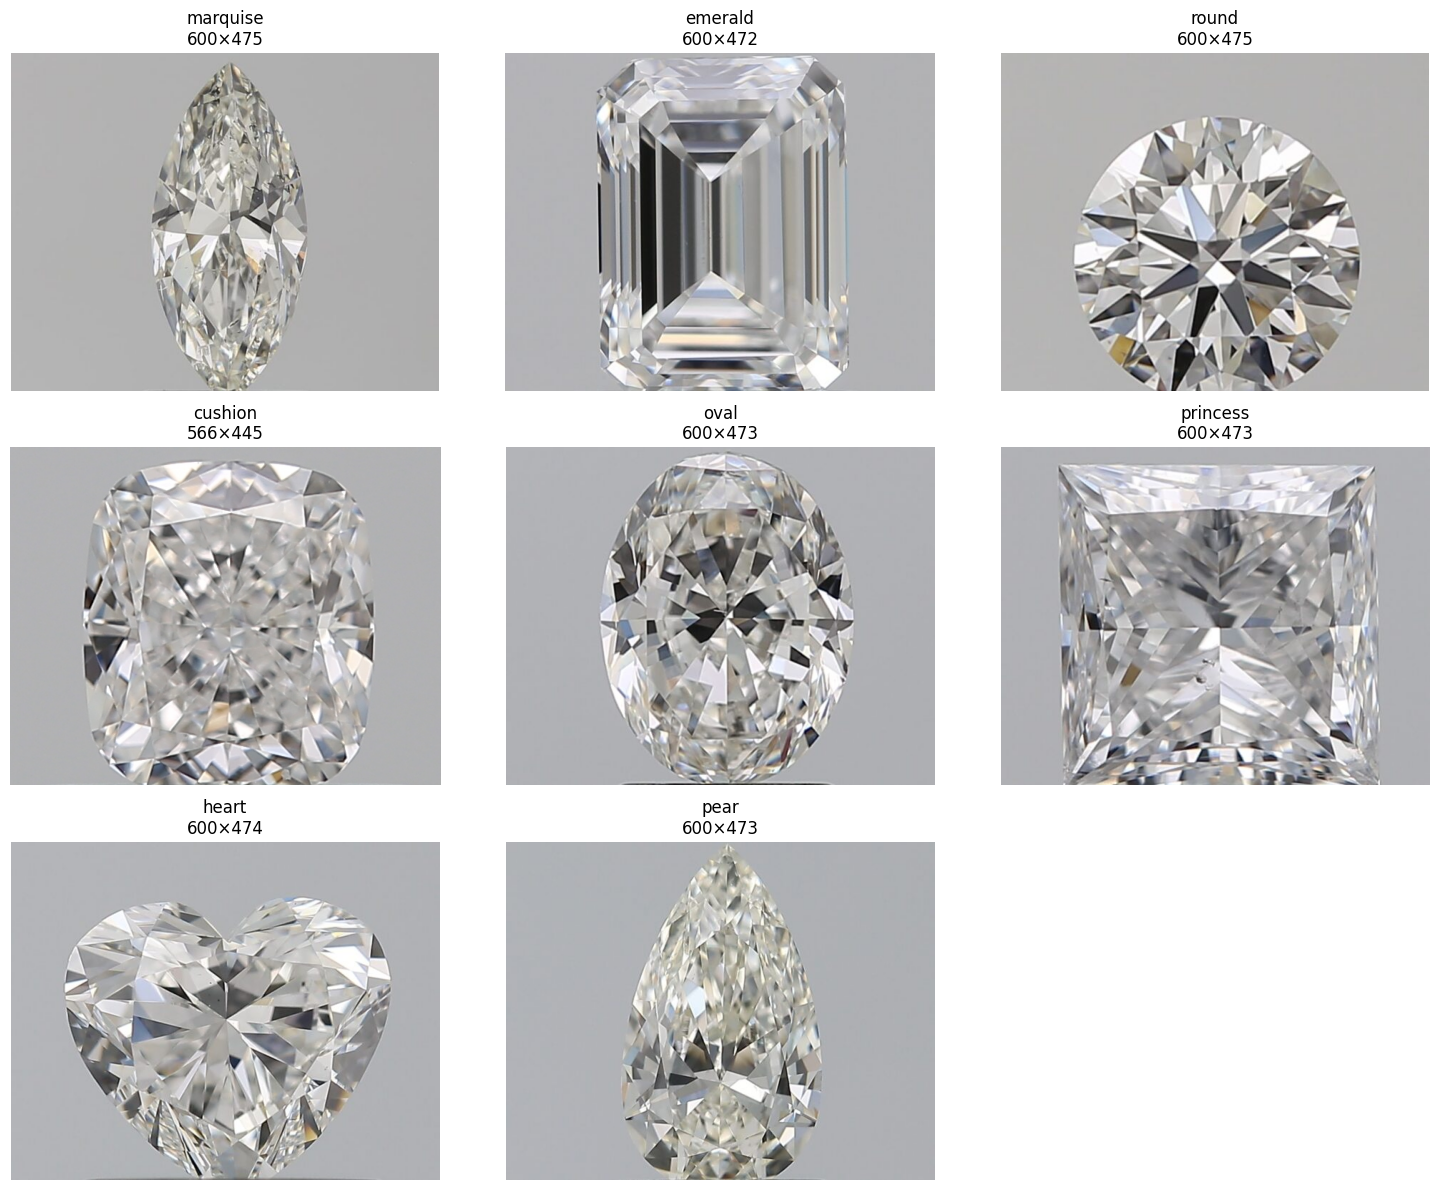

In [20]:
plt.figure(figsize=(15, 12))
row_count = (len(classes) + 2) // 3

for idx, class_name in enumerate(classes):
    if class_name in class_images:
        sample_paths = class_images[class_name]
        for i, img_path in enumerate(sample_paths):
            plt.subplot(row_count, 3, idx + 1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.width}×{img.height}")
            plt.axis('off')
            break

plt.tight_layout()
plt.show()

In [21]:
total_count = 0
class_counts = {}

classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    class_count = len(image_files)

    class_counts[class_name] = class_count
    total_count += class_count

print(f"Total gambar di dataset: {total_count}")

Total gambar di dataset: 48764


In [22]:
test_dir = os.path.join('/kaggle/working/data', "test")
os.makedirs(test_dir, exist_ok=True)

In [23]:
sampled_images = {}

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        sample_image = random.choice(image_files)
        source_path = os.path.join(class_dir, sample_image)
        dest_path = os.path.join(test_dir, f"{class_name}_{sample_image}")

        shutil.copy2(source_path, dest_path)
        os.remove(source_path)
        sampled_images[class_name] = dest_path
        print(f"Diambil: {source_path} → {dest_path}")

Diambil: /content/data/web_scraped/marquise/2131067.jpg → /kaggle/working/data/test/marquise_2131067.jpg
Diambil: /content/data/web_scraped/emerald/222118-870.jpg → /kaggle/working/data/test/emerald_222118-870.jpg
Diambil: /content/data/web_scraped/round/221059-187.jpg → /kaggle/working/data/test/round_221059-187.jpg
Diambil: /content/data/web_scraped/cushion/2129775.jpg → /kaggle/working/data/test/cushion_2129775.jpg
Diambil: /content/data/web_scraped/oval/2090004.jpg → /kaggle/working/data/test/oval_2090004.jpg
Diambil: /content/data/web_scraped/princess/2115154.jpg → /kaggle/working/data/test/princess_2115154.jpg
Diambil: /content/data/web_scraped/heart/2082644.jpg → /kaggle/working/data/test/heart_2082644.jpg
Diambil: /content/data/web_scraped/pear/2138532.jpg → /kaggle/working/data/test/pear_2138532.jpg


### Data Preprocessing

#### Split Dataset

In [24]:
# Konfigurasi awal
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SPLIT_RATIO = 0.4
SEED = 42

# Membuat dataset training & validasi awal dari direktori
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=SPLIT_RATIO,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

full_val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=SPLIT_RATIO,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Bagi validation jadi validasi dan test
val_size = len(full_val_ds) // 2
valid_ds = full_val_ds.take(val_size)
test_ds = full_val_ds.skip(val_size)

Found 48756 files belonging to 8 classes.
Using 29254 files for training.
Found 48756 files belonging to 8 classes.
Using 19502 files for validation.


In [25]:
# Cek jumlah kelas
labels = full_train_ds.class_names
print(f"Kelas terdeteksi: {labels}")
print(f"Batch - Train: {len(full_train_ds)}, Validasi: {len(valid_ds)}, Test: {len(test_ds)}")

# Hitung jumlah sampel
n_train = len(full_train_ds) * BATCH_SIZE
n_val = len(valid_ds) * BATCH_SIZE
n_test = len(test_ds) * BATCH_SIZE
n_total = n_train + n_val + n_test

print(f"\nJumlah Sampel per Set:")
print(f"  Training   : {n_train} ({n_train / n_total:.2%})")
print(f"  Validation : {n_val} ({n_val / n_total:.2%})")
print(f"  Testing    : {n_test} ({n_test / n_total:.2%})")



Kelas terdeteksi: ['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']
Batch - Train: 3657, Validasi: 1219, Test: 1219

Jumlah Sampel per Set:
  Training   : 29256 (60.00%)
  Validation : 9752 (20.00%)
  Testing    : 9752 (20.00%)


In [26]:
# Optimasi pipeline
AUTOTUNE = tf.data.AUTOTUNE
full_train_ds = full_train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [27]:
# Augmentasi data
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
])

def augment_data(img_batch, lbl_batch):
    return augment_layers(img_batch), lbl_batch

# Terapkan augmentasi ke data training
full_train_ds = full_train_ds.map(augment_data, num_parallel_calls=AUTOTUNE)


In [28]:
# Info jumlah kelas
num_classes = len(labels)

## Modelling

In [29]:
# Model CNN yang Disesuaikan untuk Klasifikasi Gambar Berlian
custom_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # Normalisasi piksel
    tf.keras.layers.Rescaling(1./255),

    # Blok Konvolusi 1
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),

    # Blok Konvolusi 2
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    # Blok Konvolusi 3
    tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    # Blok Konvolusi 4
    tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    # Klasifikasi akhir
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [30]:
# Kompilasi model
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,217,416 (100.01 MB)

 Trainable params: 26,214,920 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [31]:
# Setup direktori untuk menyimpan bobot terbaik
checkpoint_folder = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_folder, exist_ok=True)


In [32]:
# Konfigurasi callback (diperbaiki)
training_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_folder, 'best_model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.weights.h5'),
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]


In [33]:
# Callback untuk Stop Otomatis saat Akurasi Mencapai Target
class StopWhenAccuracyReached(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.95):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n🎯 Target akurasi validasi {self.target_acc*100:.1f}% tercapai! Menghentikan training.")
            self.model.stop_training = True

target_accuracy = 0.95
total_epochs = 10

# Callback custom untuk berhenti saat target akurasi tercapai
training_callbacks.append(StopWhenAccuracyReached(target_acc=target_accuracy))

In [34]:
# Hapus file CSV lama jika ada
csv_path = '/kaggle/working/data/web_scraped/diamond_data.csv'
if os.path.exists(csv_path):
    os.remove(csv_path)

In [35]:
# Training model
target_accuracy = 0.95

training_callbacks.append(StopWhenAccuracyReached(target_acc=target_accuracy))

history = custom_model.fit(
    full_train_ds,
    validation_data=valid_ds,
    epochs=total_epochs,
    callbacks=training_callbacks,
    verbose=1
)

Epoch 1/10
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8169 - loss: 2.4597
Epoch 1: val_accuracy improved from -inf to 0.07034, saving model to /kaggle/working/checkpoints/best_model_epoch01_valacc0.0703.weights.h5
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 865s 228ms/step - accuracy: 0.8169 - loss: 2.4597 - val_accuracy: 0.0703 - val_loss: 16.6784 - learning_rate: 0.0010
Epoch 2/10
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8944 - loss: 2.6988
Epoch 2: val_accuracy improved from 0.07034 to 0.98708, saving model to /kaggle/working/checkpoints/best_model_epoch02_valacc0.9871.weights.h5

🎯 Target akurasi validasi 95.0% tercapai! Menghentikan training.

🎯 Target akurasi validasi 95.0% tercapai! Menghentikan training.
3657/3657 ━━━━━━━━━━━━━━━━━━━━ 860s 227ms/step - accuracy: 0.8945 - loss: 2.6988 - val_accuracy: 0.9871 - val_loss: 1.7656 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


## Evaluasi dan Visualisasi

In [36]:
# Menentukan epoch terakhir
last_epoch_index = len(history.history['accuracy']) - 1
final_train_acc = history.history['accuracy'][last_epoch_index]
final_train_loss = history.history['loss'][last_epoch_index]

print(f"Akurasi akhir pada data training: {final_train_acc:.4f}")
print(f"Loss akhir pada data training: {final_train_loss:.4f}")

Akurasi akhir pada data training: 0.9064
Loss akhir pada data training: 2.4576


In [37]:
# Validasi terbaik
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_accuracy = history.history['val_accuracy'][best_epoch]

print(f"Skor validasi tertinggi: {best_val_accuracy:.4f} (terjadi pada epoch ke-{best_epoch + 1})")

# Evaluasi terhadap data test
test_metrics = custom_model.evaluate(test_ds, verbose=0)
print(f"Akurasi pada data uji: {test_metrics[1]:.4f}, Loss: {test_metrics[0]:.4f}")


Skor validasi tertinggi: 0.9871 (terjadi pada epoch ke-2)
Akurasi pada data uji: 0.9857, Loss: 1.7819


In [38]:
true_labels = []
predicted_labels = []

# Loop batch untuk prediksi
for batch_images, batch_labels in test_ds:
    probs = custom_model.predict(batch_images, verbose=0)
    preds = tf.argmax(probs, axis=1)

    true_labels.extend(batch_labels.numpy())
    predicted_labels.extend(preds.numpy())

In [39]:
# Ubah jadi array NumPy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [52]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=SPLIT_RATIO,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = raw_train_ds.class_names


Found 48756 files belonging to 8 classes.
Using 29254 files for training.


In [53]:
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

              precision    recall  f1-score   support

     cushion     0.9774    0.9683    0.9729      1074
     emerald     0.9898    0.9971    0.9934       678
       heart     1.0000    0.9910    0.9955       777
    marquise     1.0000    0.4302    0.6016        86
        oval     0.9830    0.9853    0.9841      1290
        pear     0.9239    0.9978    0.9595       913
    princess     0.9885    0.9810    0.9848       791
       round     0.9993    0.9971    0.9982      4141

    accuracy                         0.9856      9750
   macro avg     0.9827    0.9185    0.9362      9750
weighted avg     0.9862    0.9856    0.9848      9750



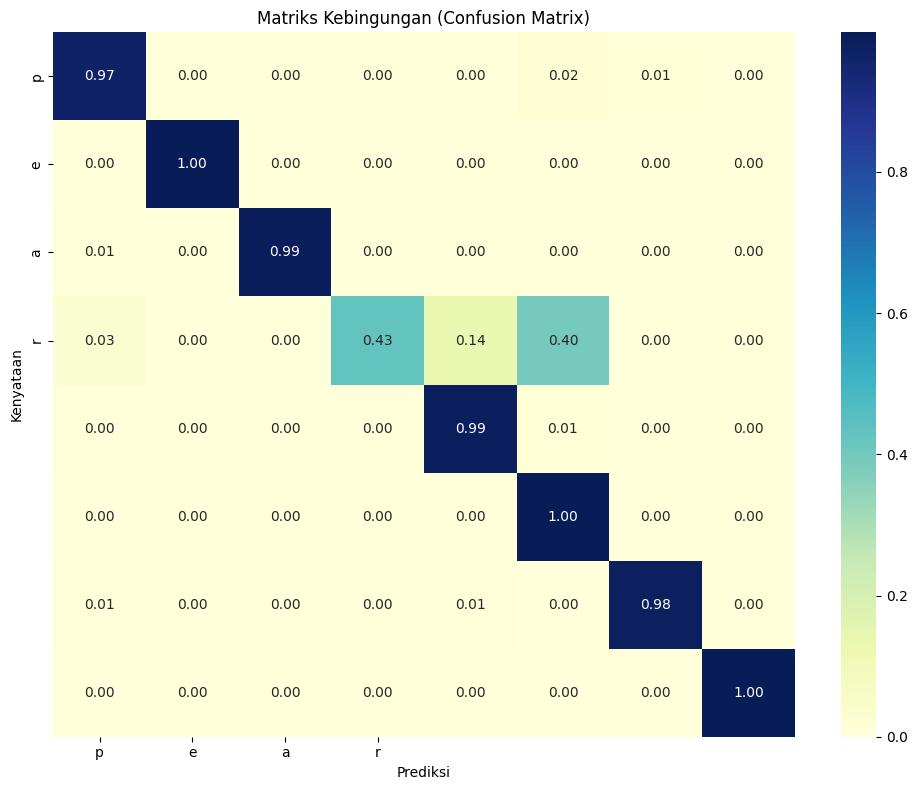

In [54]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=class_name, yticklabels=class_name)
plt.title("Matriks Kebingungan (Confusion Matrix)")
plt.xlabel("Prediksi")
plt.ylabel("Kenyataan")
plt.tight_layout()
plt.show()

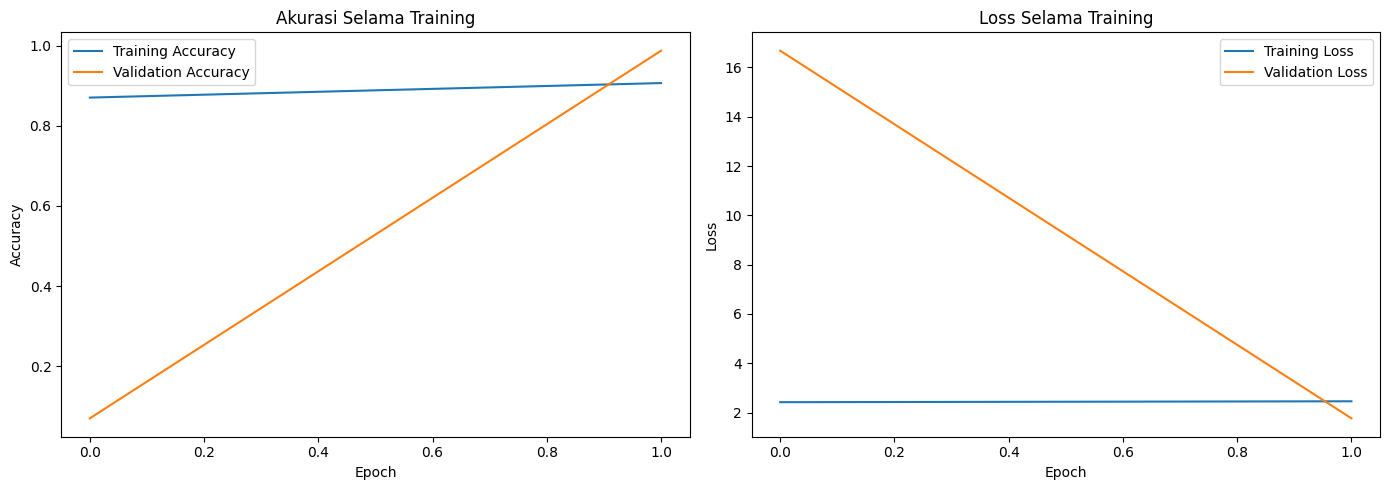

In [55]:
# Visualisasi akurasi loss

plt.figure(figsize=(14, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Akurasi Selama Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Selama Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [58]:
custom_model.save("diamond_classifier_model.h5")

### SavedModel

In [59]:
custom_model.save("diamond_classifier_model.h5")

### TF-Lite

In [88]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [90]:
# Load model Keras dari .h5
keras_model_path = "diamond_classifier_model.h5"
model = tf.keras.models.load_model(keras_model_path)

# Konversi ke TF-Lite dengan dukungan custom ops
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Simpan hasil konversi
tflite_model_path = "diamond_classifier_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model TF-Lite tersimpan di {tflite_model_path}")

Saved artifact at '/tmp/tmp9zmy17d4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float16, name=None)
Captures:
  137383847540304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847536656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847540688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847539152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847530896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847536848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847538384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847534736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847542224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137383847541840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1373838475385

### TFJS

In [91]:
!pip install tensorflowjs
!mkdir -p tfjs_model

# Konversi dari .h5 ke TFJS format
!tensorflowjs_converter \
    --input_format=keras \
    diamond_classifier_model.h5 \
    tfjs_model/

2025-06-08 09:19:09.840190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749374349.861305   40894 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749374349.867499   40894 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [92]:
import os
os.listdir()


['.config',
 'diamond_classifier_model_select_tfops.tflite',
 'sample_data',
 'data',
 'images.jfif',
 'diamond_classifier_model.h5',
 'diamond_classifier_model.tflite',
 'tfjs_model']

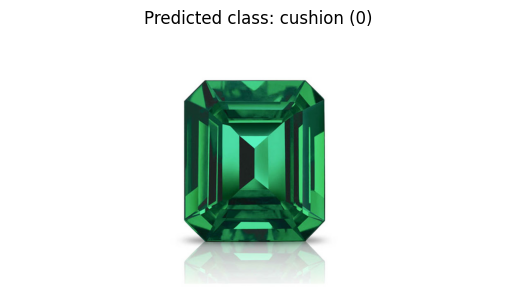

In [99]:
# Load model TF-Lite dan allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi preprocessing gambar input
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0).astype(np.float32)

uploaded_path = "test_image.jpg"
if not os.path.exists(uploaded_path):
    raise FileNotFoundError(f"Gambar uji tidak ditemukan: {uploaded_path}")

input_data = load_image(uploaded_path)

# Inference dengan TF-Lite
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

# Mapping hasil ke class
class_names = raw_train_ds.class_names
predicted_class = np.argmax(output)

# Tampilkan gambar + prediksi
plt.imshow(Image.open(uploaded_path))
plt.title(f"Predicted class: {class_names[predicted_class]} ({predicted_class})")
plt.axis('off')
plt.show()

#Save

In [103]:
import os
import shutil
import glob

# Direktori utama
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)

# TFLite
shutil.copy("diamond_classifier_model_select_tfops.tflite", "submission/tflite/model.tflite")

# Simpan label.txt
labels = ['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']
with open("submission/tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

In [105]:
# Simpan saved_model
model = tf.keras.models.load_model("diamond_classifier_model.h5")
model.export("submission/saved_model")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float16, name=None)
Captures:
  137382663498704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663501776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663501008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663502352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663501584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663502736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382663503120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382660145424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137382660146192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1373826

In [109]:
import os
[f for f in os.listdir() if f.endswith(".ipynb")]


[]

In [108]:
shutil.copy("notebook.ipynb", "submission/notebook.ipynb")

# Tulis README dan requirements
with open("submission/README.md", "w") as f:
    f.write("# Diamond Shape Classification\n\nDeskripsi singkat proyek.")

with open("submission/requirements.txt", "w") as f:
    f.write("tensorflow\ntensorflowjs\npillow\nmatplotlib\n")


FileNotFoundError: [Errno 2] No such file or directory: 'New Klasifikasi.ipynb'